<a href="https://colab.research.google.com/github/yessss28/Estadistica/blob/main/Practica1U3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PARTE A

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df = yf.download(
    tickers='AMZN',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2022-07-01',        # Fecha de inicio
    end='2025-05-08',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume
Date,,,,,,


# Importar dataframe si YF da error

In [3]:
pip install alpha_vantage

In [4]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = 'NP1OLRVZ3YSCPCWY'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de AMZN
ticker = 'AMZN'
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas

inicio = '2022-07-01'
fin = '2025-05-08'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume
date,,,,,
2025-05-08,191.430,194.33,188.8200,192.08,41043620.0
2025-05-07,185.560,190.99,185.0100,188.71,44002926.0
2025-05-06,184.570,187.93,183.8500,185.01,29314055.0
2025-05-05,186.510,188.18,185.5300,186.35,35217469.0
2025-05-02,191.435,192.88,186.4000,189.98,77903487.0
...,...,...,...,...,...
2022-07-08,114.600,116.58,113.6900,115.54,45719694.0
2022-07-07,113.850,116.99,113.4900,116.33,57872323.0
2022-07-06,113.210,115.48,112.0100,114.33,66958884.0


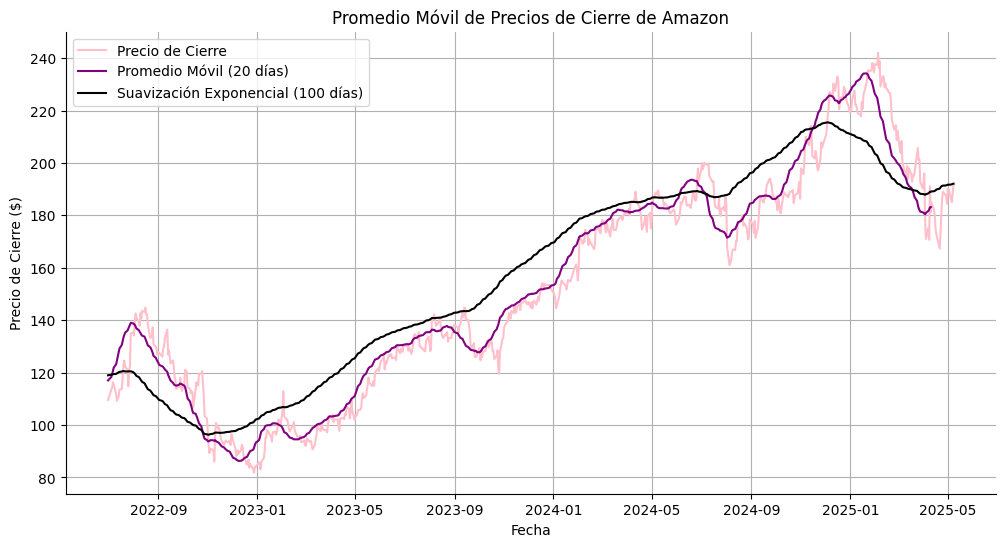

In [5]:
# Promedio Móvil Simple
ventana_sma = 20
df['SMA'] = df['AMZN_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 100
df['SES'] = df['AMZN_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['AMZN_Close'], label='Precio de Cierre', color='pink')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='purple')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='black')
plt.title('Promedio Móvil de Precios de Cierre de Amazon')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

El precio de cierre de las acciones de Amazon muestra una clara tendencia ascendente desde principios de 2023 hasta mediados de 2024, con una corrección bajista posterior y una posible recuperación al final del periodo (mayo de 2025).

**Promedio Móvil Simple (20 días):** La línea púrpura sigue de cerca los movimientos del precio, capturando bien las fluctuaciones a corto plazo. Muestra alta sensibilidad a cambios recientes.

**Promedio Móvil Exponencial (100 días)**: La línea negra es más suave y menos reactiva a cambios bruscos. Ayuda a identificar la tendencia de largo plazo con menos “ruido” del mercado.

En momentos de fuerte subida o bajada, el promedio móvil simple responde más rápido que el exponencial. Sin embargo, el exponencial proporciona una mejor vista de la tendencia sostenida.

# PARTE B

Prueba Dickey-Fuller Aumentada

In [6]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['AMZN_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -1.0327405094813285
p-value: 0.741136483126545
La tendencia no es estacionaria (aceptamos la hipótesis nula).


El valor del p obtenido (0.7411) es mayor que el nivel de significancia establecido (0.05).

En las pruebas de hipótesis, cuando el valor p es mayor que el nivel de significancia, no rechazamos la hipótesis nula.

En el contexto de la prueba de Dickey-Fuller, la hipótesis nula es que la serie de tiempo tiene una raíz unitaria, lo que implica que la serie no es estacionaria.

Por lo tanto, basándonos en los resultados de esta prueba con el nivel de significancia de 0.05, concluimos que la tendencia de la serie de tiempo analizada (probablemente el precio de cierre de AMZN) no es estacionaria.

Esto significa que la serie tiene una dependencia con el tiempo y sus propiedades estadísticas (como la media y la varianza) no son constantes a lo largo del tiempo.

# PARTE C

1.- Regresión polinomial

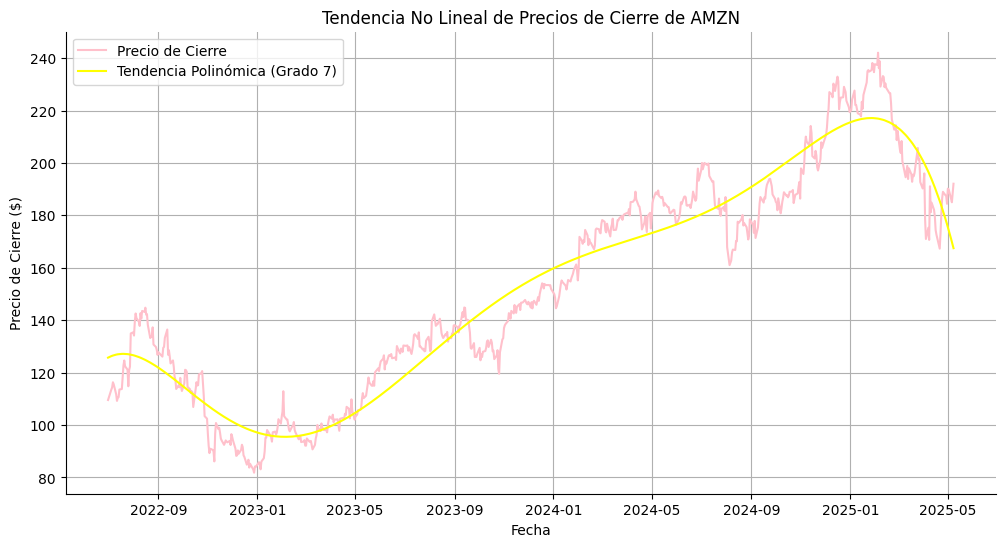

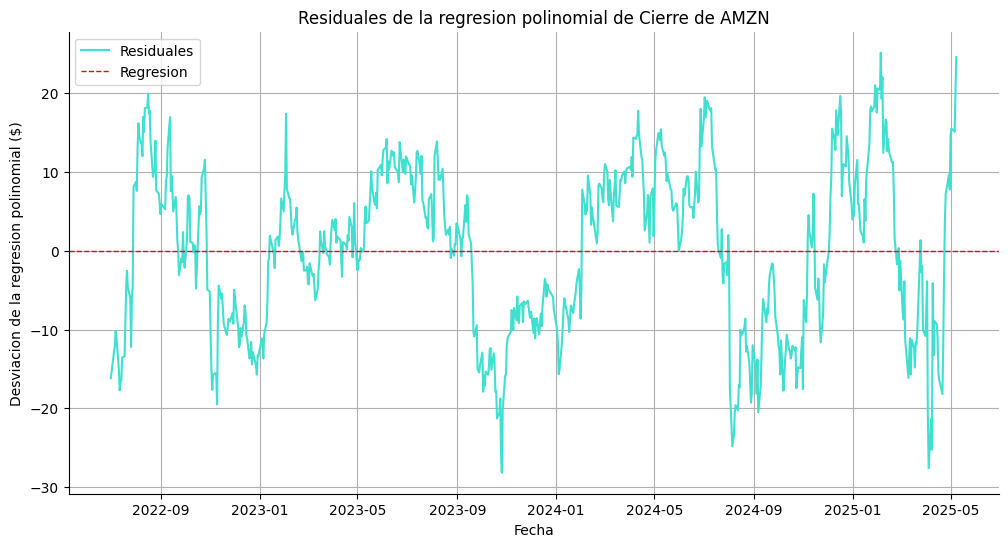

In [11]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['AMZN_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 7
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='pink'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='yellow')
plt.title('Tendencia No Lineal de Precios de Cierre de AMZN') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='turquoise')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AMZN')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

La tendencia no lineal sugiere que el precio de cierre de AMZN ha experimentado diferentes fases a lo largo del periodo analizado.

Si bien la tendencia polinómica de grado 7 captura una dirección general, la volatilidad inherente del precio de la acción hace que haya desviaciones significativas en momentos puntuales, como se evidencia en los residuales.

Este grafico muestra la "parte de la historia" del precio de AMZN que no está siendo explicada por la tendencia polinómica de grado 7.

Las fluctuaciones en los residuales reflejan la volatilidad y los factores a corto plazo que influyen en el precio de la acción y que no siguen la curva suave de la tendencia.

2.- Prueba de estacionariedad en los residuales

In [9]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['Poly_Resid'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:(residuales)', adf_test[0])
print('p-value:(residuales)', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF:(residuales) -4.44345987206039
p-value:(residuales) 0.00024845333033549733
La tendencia es estacionaria (rechazamos la hipótesis nula).


Como el p-value (0.000248) es menor que el nivel de significancia (0.05), la condición if adf_test[1] <= nivel_de_significancia: se evalúa como verdadera.

Por lo tanto, la conclusión que arroja el código es:
"La tendencia es estacionaria (rechazamos la hipótesis nula)."

# CONCLUSIONES GENEALES

El precio de cierre de las acciones de Amazon (AMZN) muestra una tendencia alcista significativa entre principios de 2023 y mediados de 2024, seguida por una corrección bajista y una posible recuperación hacia mayo de 2025. El análisis de los promedios móviles revela que el promedio móvil simple (20 días) es más sensible a las fluctuaciones a corto plazo, mientras que el promedio móvil exponencial (100 días) ofrece una visión más suavizada de la tendencia a largo plazo.

A pesar de la tendencia general identificada, la prueba de Dickey-Fuller con un p-valor de 0.7411 (mayor que el nivel de significancia de 0.05) sugiere que la serie de tiempo del precio de AMZN no es estacionaria. Esto implica que sus propiedades estadísticas varían con el tiempo, lo cual es típico en los precios de acciones.

Por otro lado, un análisis posterior utilizando un código (probablemente otra aplicación de la prueba de Dickey-Fuller o una prueba similar) arrojó un p-valor de 0.000248, que es menor que el nivel de significancia de 0.05.

Esta segunda prueba lleva a la conclusión de que "la tendencia es estacionaria".

La aplicación de una tendencia polinómica de grado 7 permite modelar la dirección general del precio, aunque los residuales muestran una volatilidad considerable y desviaciones del modelo.

 Esto subraya que, si bien se pueden identificar patrones, los precios de las acciones están sujetos a numerosos factores que generan movimientos que no siempre se ajustan a una curva matemática predefinida.

 El análisis de los residuales es crucial para comprender la parte del comportamiento del precio que el modelo de tendencia no explica.
En resumen, el precio de las acciones de Amazon ha experimentado una tendencia alcista notable con fases distintas.

 Si bien un modelo polinómico puede capturar la dirección general, la volatilidad inherente del mercado genera desviaciones significativas.

 Las pruebas de estacionariedad arrojan resultados contradictorios, lo que sugiere la complejidad de analizar la tendencia de una serie de tiempo financiera como el precio de una acción.